# Assignment 2: CudaVision
------
### Group Members:
__1.__ Saikat Roy

__2.__ Albert Gubaidullin

## Import Dependencies
------

In [1]:
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import dataloader, random_split

from torchvision import datasets, transforms

import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid

## Softmax Regression MLP object
------
The `SoftmaxRegressionMLP` class is a basic object to create a MLP with ReLU hidden units and a linear output unit (argmax(x) is the same as argmax(softmax(x))

In [2]:
class SoftmaxRegressionMLP(nn.Module):

    def __init__(self, n_input, n_hidden_layers, n_output, h_units):
        """
        Initialization for a simply softmax regression MLP model with ReLU activations in hidden layers
        :param n_input (int): Number of input units to network
        :param n_hidden_layers (int): Number of hidden layers in network
        :param n_output (int): Number of output units of network
        :param h_units (int or list): hidden unit count or list of hidden units in each hidden layer of network
        """
        super(SoftmaxRegressionMLP, self).__init__()
        self.n_out = n_output

        layers = []

        def add_layer_and_act(n_inp, n_out, nl_type):
            if nl_type is None:
                return [nn.Linear(n_inp, n_out)]
            return [nn.Linear(n_inp, n_out), self.non_lin(nl_type)]

        # Add input layers
        if type(h_units) is list:
            layers.extend(add_layer_and_act(n_input, h_units[0], 'relu'))
        else:
            layers.extend(add_layer_and_act(n_input, h_units, 'relu'))

        # Add hidden layers
        if n_hidden_layers>1:
            for i in range(1, n_hidden_layers):
                if type(h_units) is list:
                    layers.extend(add_layer_and_act(h_units[i-1], h_units[i], 'relu'))
                else:
                    layers.extend(add_layer_and_act(h_units, h_units, 'relu'))

        # Add output layer
        if type(h_units) is list:
            layers.extend(add_layer_and_act(h_units[-1], self.n_out, None))
        else:
            layers.extend(add_layer_and_act(h_units, self.n_out, None))

        self.block = nn.Sequential(*layers)

    def forward(self, x):
        """
        Simple forward pass
        :param x:
        :return:
        """
        return self.block(x)

    def non_lin(self, nl_type='sigmoid'):
        """
        Simply plugs in a predefined non-linearity from a dictionary to be used throughout the network
        :param nl_type: type based on predefined types. Defaults to sigmoid on wrong type.
        :return:
        """
        nl = {'sigmoid': nn.Sigmoid(), 'relu': nn.ReLU(), 'softmax': nn.Softmax(self.n_out)}
        try:
            return nl[nl_type]
        except:
            print("non linearity type not found. Defaulting to sigmoid.")
            return

## Method for training model in PyTorch
------
The `train` method takes a dataloader object and trains the model on it for the specified amount of iterations and returns the loss per iteration as a list

In [43]:
def train(dataloader, iters = 20, suppress_output=False):
    """
    Trains the model on the given dataloader and returns the loss per epoch
    :param dataloader: The autoencoder is trained on the dataloader
    :param iters: iterations for training
    :return:
    """

    loss_l = []
    for itr in range(iters):
        av_itr_loss = 0.0
        for batch_id, (x, y) in enumerate(dataloader):
            optimizer.zero_grad()
            # print(x)
            x = x.cuda()
            y = y.cuda()
            # x = (x>0.5).float() * 1
            x = x.view(batch_size, -1)
            # print(x[0])
            preds = model(x)
            # print((z==1).sum())
            batch_loss = loss(preds, y)
            batch_loss.backward()
            optimizer.step()
            av_itr_loss += (1/batch_size)*batch_loss.item()
        loss_l.append(av_itr_loss)
        if not suppress_output:
            print("Epoch {}: Loss={}".format(itr, av_itr_loss))
    return loss_l


## Method for calculating accuracy
------
The `acc` method simply calculates the predictive accuracy of a model on the given dataloader. It returns the true labels, predicted labels and the accuracy as a float in the range [0,1]

In [44]:
def acc(dataloader):
    """
    Calculate accuracy of predictions from model for dataloader.
    :param dataloader: dataloader to evaluate
    :return:
    """
    acc = 0.0
    true_y = []
    pred_y = []
    total = 0.0
    with torch.no_grad():
        for batch_id, (x, y) in enumerate(dataloader):
            x = x.cuda()
            y = y.cuda()
            x = x.view(batch_size, -1)
            # print(x[0])
            preds = model(x)
            preds = torch.argmax(preds, dim=1)
            acc += ((preds==y).sum().item())
            total+= y.size(0)

            true_y.extend(list(preds.view(-1).cpu().numpy()))
            pred_y.extend(list(y.view(-1).cpu().numpy()))

        acc/=total
    return true_y, pred_y, acc

## Method for plotting confusion matrix
------
__Please note that this function has been borrowed from the sklearn tutorial regarding the visualization of confusion matrices__. The function has however had minor modification to shorten its outputs and increase the figure size.

https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

In [45]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
"""
THIS CONFUSION MATRIX FUNCTION HAS BEEN BORROWED FROM THE SCIKIT-LEARN TUTORIAL ON GENERATING VISUAL CONFUSION MATRIX
PLOTS. REINVENTING THE WHEEL IN THIS CASE SEEMED TO BE EXTREMELY REDUNDANT.
"""

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
#     print(unique_labels(y_true, y_pred))
#     classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#   print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    
    # Resize the subplots
    plt.subplots_adjust(left=0.0, right=1.0, bottom=0.0, top=1.0)

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
#     fig.tight_layout()
    return ax

## Initializing Models, Hyperparameters and Datasets
-------
The Models, Dataloaders and some training hyperparameters are initialized. The neural network architecture used is __3072-128-128-10__.

In [49]:
    batch_size = 64
    n_itr = 50
    lr = 0.01

    model = SoftmaxRegressionMLP(1024*3, 2, 10, 128).cuda()
    print(model)

    transform_list = transforms.Compose([#transforms.Grayscale(),
                                         transforms.ToTensor()])
    trainset = datasets.CIFAR10('./data', train=True, download=True, transform=transform_list)
    testset = datasets.CIFAR10('./data', train=False, download=True, transform=transform_list)

    train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, drop_last=True)
    test_dataloader  = torch.utils.data.DataLoader(testset,  batch_size=batch_size, shuffle=False, drop_last=True)

SoftmaxRegressionMLP(
  (block): Sequential(
    (0): Linear(in_features=3072, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)
Files already downloaded and verified
Files already downloaded and verified


## Training the model
------
The model is trained using `SGD` and `CrossEntropy` Loss. 

In [50]:
print("\nTraining on Cross Entropy Loss:")
loss_type = "Cross_Entropy"
model.train()
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
loss_list = train(train_dataloader, iters=n_itr)


Training on Cross Entropy Loss:
Epoch 0: Loss=23.07614135183394
Epoch 1: Loss=20.590666675940156
Epoch 2: Loss=19.601702466607094
Epoch 3: Loss=18.957581259310246
Epoch 4: Loss=18.344603531062603
Epoch 5: Loss=18.00105607137084
Epoch 6: Loss=17.60221173427999
Epoch 7: Loss=17.26150164939463
Epoch 8: Loss=17.034407563507557
Epoch 9: Loss=16.781784594990313
Epoch 10: Loss=16.485002517700195
Epoch 11: Loss=16.17850120086223
Epoch 12: Loss=16.047695946879685
Epoch 13: Loss=15.85420316644013
Epoch 14: Loss=15.576063729822636
Epoch 15: Loss=15.377803176641464
Epoch 16: Loss=15.247486769221723
Epoch 17: Loss=15.186762042343616
Epoch 18: Loss=14.925677450373769
Epoch 19: Loss=14.787217980250716
Epoch 20: Loss=14.717392784543335
Epoch 21: Loss=14.5908721126616
Epoch 22: Loss=14.379273660480976
Epoch 23: Loss=14.321690091863275
Epoch 24: Loss=14.235830928198993
Epoch 25: Loss=14.002429158426821
Epoch 26: Loss=13.885597644373775
Epoch 27: Loss=13.774763474240899
Epoch 28: Loss=13.67004238255322


## Plotting the loss
------
The training loss has been plotted against the number of iterations.

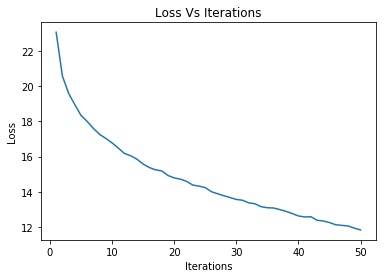

In [51]:
plt.plot(np.linspace(1,n_itr,n_itr),loss_list)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Loss Vs Iterations")
plt.savefig("loss.png", format='png', transparent=False, pad_inches=0.1)
plt.show()

## Calculating the accuracy on the Training and Test Sets
------


In [52]:
preds, true_labels, train_acc = acc(train_dataloader)
print("Train Acc={}".format(train_acc))

preds, true_labels, test_acc = acc(test_dataloader)
print("Test Acc={}".format(test_acc))

Train Acc=0.6647127080665813
Test Acc=0.51171875


## Calculating and Plotting the Confusion Matrix
------
The confusion matrix for the test set is plotted 

Normalized confusion matrix


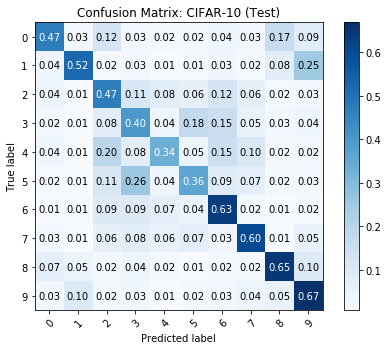

In [53]:
conf = plot_confusion_matrix(true_labels, preds, [str(i) for i in range(10)], normalize=True,\
                         title="Confusion Matrix: CIFAR-10 (Test)")

## K-Fold (Monte-Carlo) Cross Validation for hyperparameter search
------
K-Fold (Monte-Carlo) Cross Validation has been used to verify the accuracy on a validation set created by a 80-20 split on the training set. `ParameterGrid` from `sklearn` has been used to generate sets of hyperparameters while the accuracies on a random validation set are used to choose between parameter sets.

In [ ]:
parameter_grid = {"lr":[0.1, 0.05, 0.01, 0.005, 0.001, 0.0001],
                  "batch_size": [32, 64, 128]
                  }

# itr = 2
#
# parameter_grid = {"lr":[0.1],
#                   "batch_size": [32]
#                   }

# K-Fold cross validation on learning rate and batch size
k_fold = 3

best_model = None
best_lr = 0
best_batch = 0
best_acc = 0

for p in ParameterGrid(parameter_grid):
    lr = p['lr']
    batch_size = p['batch_size']
    p_acc_valid = 0.0

    for k in range(k_fold):
        model = SoftmaxRegressionMLP(1024*3, 2, 10, 128).cuda()

        train_split, valid_split = random_split(trainset, [ int(len(trainset)*0.8), int(len(trainset)-(len(trainset)*0.8))])
        train_dataloader = torch.utils.data.DataLoader(train_split, batch_size=batch_size, shuffle=True,
                                                       drop_last=True)
        valid_dataloader = torch.utils.data.DataLoader(valid_split, batch_size=batch_size, shuffle=True,
                                                       drop_last=True)

        model.train()
        loss = nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
        _ = train(train_dataloader, iters=n_itr, suppress_output=True)

        _, _, valid_acc = acc(valid_dataloader)

        p_acc_valid += valid_acc/k_fold

    print("Batch Size:{}, Learning Rate={}, Acc={}".format(batch_size, lr, p_acc_valid))
    if p_acc_valid>best_acc:
        print("Best parameters so far. Saved.")
        best_acc = p_acc_valid
        best_lr = lr
        best_batch = batch_size
        best_model = model


batch_size = best_batch
model = best_model
print("Best parameters on {}-fold Monte-Carlo Cross Validation on 80-20 split.\n Batch Size:{}, Learning Rate={} "\
      .format(k_fold, batch_size, best_lr))

# Reinitializing dataloader with best batch size
test_dataloader  = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, drop_last=True)
preds, true, test_acc = acc(test_dataloader)
print("Accuracy on Test Set={}".format(test_acc))
